## Pixel and Image Classification on a Sentinel-2 Time Series Part1

In [2]:
# import some modules
import numpy as np
import pandas as pd
import rasterio
from rasterio.mask import mask
import geopandas as gpd
from shapely.geometry import mapping
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib as mpl
import os
# utility
from sklearn.preprocessing import StandardScaler, QuantileTransformer, PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score, GridSearchCV, StratifiedShuffleSplit, StratifiedKFold
from sklearn.model_selection import train_test_split
# models
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn import svm
from sklearn.linear_model import Perceptron
from sklearn.neural_network import MLPClassifier
import tensorflow as tf
import warnings

warnings.filterwarnings('ignore')
%matplotlib inline

2022-11-28 15:49:29.272561: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-28 15:49:29.272602: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


**a) Select a geographic area of interest and download 
three (3) Sentinel-2 Level1C images separated by at least one year each using Google Earth Engine in Python.**

The geographic area of interest is the east Attika in Greece. This area combines different land cover/use like vegetation, water (sea, pools), residential, crops, highway, rocky hills, bare soil and intustries. Using Google earth engine five images from Sentinel 2 were downloaded and saved in the google drive. For the further analysis three of them were used, the images from the years 2016, 2019 and 2020 that all of them correspond to the same month (August).

At fisrt was imported and initialized the Google Earth Engine.

In [3]:
import ee
ee.Authenticate()
ee.Initialize()

Enter verification code: 4/1AfgeXvuKJEY6SASCM_Dl4hQzF45KsQnug5aoMf11R1IAKHXvKKOgv7Xgdbc

Successfully saved authorization token.


In [4]:
# variable name for Sentinel 2 collection on Earth Engine
collection = 'COPERNICUS/S2'
# provide a short name for the area of interest
area_name = 'Athens'

In the following for loop I created an image collection, filtering by: collection name, given by our 'collection' variable, an area of interest, given by the 'AOI' variable the date range, given by our 'time_range' variable and the maximum cloudiness, given by the 'max_cloud_percent' variable. Initially the max cloud percent was 1 but this had as a result only 2 images to be downladed. For that reason the cloud percent was changed to 5. I selected 10 bands and I rescaled them by 1000. In the for loop I also provided the region of interest for clipping and finally the outpot spatial resolution.

In [5]:
for i in range(2015,2021):
    drive_folder = 'Attiki_sentinel2_level1C'
    time_range = ['%02d-08-01' %(i), '%02d-08-31' % (i)]
    # the maximum percentage of clouds we would like in the scene
    max_cloud_percent = 5
    band_list = ['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B11', 'B12']
    # spatial resolution for output raster in meters
    # if not already at this resolution, then the selected bands will be resampled to it
    spatial_resolution = 10

    # bounding box coordinates in the format: xmin, ymin, xmax, ymax
    bbox_coords = [23.86, 38,24.00, 38.14] # East Athens, 
    
    # create a geometry object using the bounding box coordinates
    AOI = ee.Geometry.Rectangle(bbox_coords)

    # image collection
    image_collection = ee.ImageCollection(collection).\
                     filterBounds(AOI).\
                     filterDate(time_range[0], time_range[1]).\
                     filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', max_cloud_percent))

    # we only want one image from the selected time range, which we pick out here
    first_img = image_collection.first()
    # we get the output filename for the image using the product metadata
    filename = '04_' + first_img.getInfo()['properties']['PRODUCT_ID'] + '_' + area_name + '%02d_Aug'%(i)
    print(filename)
    
    export_job = ee.batch.Export.image.toDrive(
        first_img.select(band_list).divide(10000), 
        description=filename, 
        folder=drive_folder,
        region=AOI.getInfo()['coordinates'],
        scale=spatial_resolution) 
    # we have to actually start the job
    export_job.start()
    # and let's see if it's running
    print('job status: {}'.format(export_job.status()['state']))

04_S2A_OPER_PRD_MSIL1C_PDMC_20160518T155850_R050_V20150805T091005_20150805T091005_Athens2015_Aug
job status: READY
04_S2A_MSIL1C_20160819T091032_N0204_R050_T34SGH_20160819T091909_Athens2016_Aug
job status: READY
04_S2A_MSIL1C_20170804T091031_N0205_R050_T34SGH_20170804T091836_Athens2017_Aug
job status: READY
04_S2B_MSIL1C_20180804T090549_N0206_R050_T34SGH_20180804T131329_Athens2018_Aug
job status: READY
04_S2B_MSIL1C_20190809T090559_N0208_R050_T34SGH_20190809T112133_Athens2019_Aug
job status: READY
04_S2B_MSIL1C_20200803T090559_N0209_R050_T34SGH_20200803T113141_Athens2020_Aug
job status: READY


**(b) Create separate label shapefiles for each of the three images in your favorite GIS (may I suggest QGIS?). Use at least 5 label classes of your choosing (e.g., forest, desert, snow, buildings, roads, etc.). This depends on the content of your chosen geographic area! The classes should be the same between the different scenes.**

Using the QGIS three shapefiles were created corresponding to the three images. Each shapefile contains 7 classes (polygons : asphalt, bare soil, cement, rocks, tiled roof, vegetation, water) that will be used later to train the models.

In [6]:
# from IPython.display import Image
# Image(filename='b.png')
#Image(filename='a.png')

**(c) For each scene: use the training data you created to train a few ML models of your choice (at least 3 different models). Estimate the accuracy of your models via cross-validation. For at least one of the models you've trained, do a hyperparameter tuning, and report the accuracy computed via nested cross-validation.**

In this step three ML models were created :KNN, SVC and MLPClassifier. It has to be mentioned that the last one is more advanced model and "closer" to deep learning. Before creating the models I loaded the three images rescaling the range 0-0.275 in the first three bands to 8-bit 1-255 (reserving 0 for no data).  I plotted the clipped areas before and after the rescale. After that I changed the projection system of the shapefiles in order both images and shapefiles have the same projections. Combining the polygons of the shapefiles and the pixels of the image, in a for loop, i created an array of the raster pixels within these polygons. I eliminated all the pixels with 0 values for all bands and finally appended the labels to an y array and stacking the pixels onto a pixel array. The next step was the plot of the reflectances versus the bands and the wavelength exploring the spectral signatures. The pixel values  and the associated class of each pixel were saved as npy files. Now the saved data (training data) can be loaded and be processed with the prediction data (images) after the prediction data have first been reshaped in order to be created anarray of pixels and values. It was also necessary the preprocessing of data.

In [7]:
# variables for data filepaths
sentinel_fp = '04_S2A_MSIL1C_20160819T091032_N0204_R050_T34SGH_20160819T091909_Athens2016_Aug.tif'
sentinel_fp_1 = '04_S2B_MSIL1C_20190809T090559_N0208_R050_T34SGH_20190809T112133_Athens2019_Aug.tif'
sentinel_fp_2 = '04_S2B_MSIL1C_20200803T090559_N0209_R050_T34SGH_20200803T113141_Athens2020_Aug.tif'
label_fp = '2016.shp'
label_fp_1 = '2019_A.shp'
label_fp_2 = '2020.shp'
# variable with band list
band_list = ['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B11', 'B12']
# variable with center wavelength for each band (in nanometers)
band_wavelengths = [490, 560, 665, 705, 740, 783, 842, 865, 1610, 2190]

In [8]:
# load the sentinel scene and print the metadata
full_dataset = rasterio.open(sentinel_fp) #2016
full_dataset_1 = rasterio.open(sentinel_fp_1) #2019
full_dataset_2 = rasterio.open(sentinel_fp_2) #2020

# assign the number of bands to a variable
n_bands = full_dataset.count
n_bands_1 = full_dataset_1.count
n_bands_2 = full_dataset_2.count

**Images East Athens 2016, 2019, 2020**

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(3, 1594, 1279)
Image shape Athens 2016: (1594, 1279, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(3, 1594, 1279)
Image shape Athens 2019: (1594, 1279, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(3, 1594, 1279)
Image shape Athens 2020: (1594, 1279, 3)


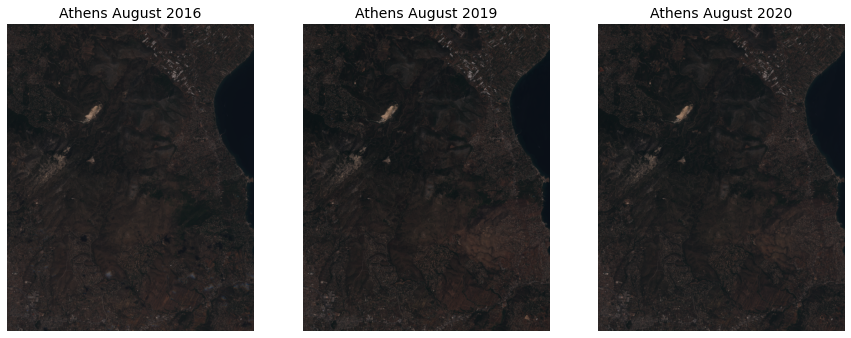

In [9]:
# show the raster
# bands 3, 2, and 1 correspond to Sentinel-2 bands for red (Band 4), green (Band 3), and blue (Band 2), respectively
img = full_dataset.read([3,2,1])
print(img.shape)
# we need to move the band-depth axis to the last dimension for plotting
img = np.moveaxis(img, 0, -1)
print('Image shape Athens 2016:',img.shape)
fig, axs = plt.subplots(1,3, figsize=(15,13))

axs[0].imshow(img)
axs[0].set_title('Athens August 2016', fontsize=14)
axs[0].set_axis_off()

img_1 = full_dataset_1.read([3,2,1])
print(img_1.shape)
img_1 = np.moveaxis(img_1, 0, -1)
print('Image shape Athens 2019:',img_1.shape)

#fig, ax = plt.subplots(figsize=(10,7))
axs[1].imshow(img_1)
axs[1].set_title('Athens August 2019', fontsize=14)
axs[1].set_axis_off()

img_2 = full_dataset_2.read([3,2,1])
print(img_2.shape)
img_2 = np.moveaxis(img_2, 0, -1)
print('Image shape Athens 2020:',img_2.shape)
axs[2].imshow(img_2)
axs[2].set_title('Athens August 2020', fontsize=14)
axs[2].set_axis_off()

In [10]:
#2016 here we rescale the range 0-0.275 in our first three bands to 8-bit 1-255 (reserving 0 for no data)
!gdal_translate -of JPEG -co QUALITY=100 \
    -ot Byte -a_nodata 0 -scale 0 0.275 1 255 \
    -b 3 -b 2 -b 1 -of JPEG \
    04_S2A_MSIL1C_20160819T091032_N0204_R050_T34SGH_20160819T091909_Athens2016_Aug.tif \
    04_sentinel_Athens_2016_rgb_8bit.jpg

#2019 here we rescale the range 0-0.275 in our first three bands to 8-bit 1-255 (reserving 0 for no data)
!gdal_translate -of JPEG -co QUALITY=100 \
    -ot Byte -a_nodata 0 -scale 0 0.275 1 255 \
    -b 3 -b 2 -b 1 -of JPEG \
    04_S2B_MSIL1C_20190809T090559_N0208_R050_T34SGH_20190809T112133_Athens2019_Aug.tif \
    04_sentinel_Athens_2019_rgb_8bit.jpg

# 2020 here we rescale the range 0-0.275 in our first three bands to 8-bit 1-255 (reserving 0 for no data)
!gdal_translate -of JPEG -co QUALITY=100 \
    -ot Byte -a_nodata 0 -scale 0 0.275 1 255 \
    -b 3 -b 2 -b 1 -of JPEG \
    04_S2B_MSIL1C_20200803T090559_N0209_R050_T34SGH_20200803T113141_Athens2020_Aug.tif \
    04_sentinel_Athens_2020_rgb_8bit.jpg

Input file size is 1279, 1594
0...10...20...30...40...50...60...70...80...90...100 - done.
Input file size is 1279, 1594
0...10...20...30...40...50...60...70...80...90...100 - done.
Input file size is 1279, 1594
0...10...20...30...40...50...60...70...80...90...100 - done.


Text(0.5, 1.0, 'Athens August 2020')

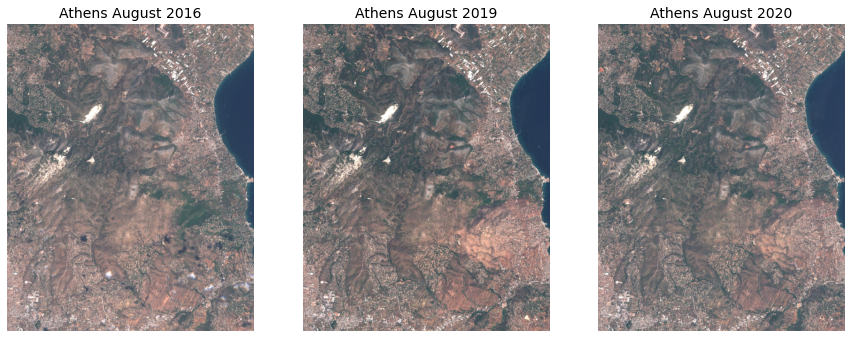

In [11]:
# let's load the images 2016, 2019 and 2020 and plot them
fig, axs = plt.subplots(1,3, figsize=(15,13))

rgb_fp = '04_sentinel_Athens_2016_rgb_8bit.jpg'
img = mpimg.imread(rgb_fp)
axs[0].imshow(img)
axs[0].set_axis_off()
axs[0].set_title('Athens August 2016', fontsize=14)

rgb_fp_1 = '04_sentinel_Athens_2019_rgb_8bit.jpg'
img_1 = mpimg.imread(rgb_fp_1)
axs[1].imshow(img_1)
axs[1].set_axis_off()
axs[1].set_title('Athens August 2019', fontsize=14)

rgb_fp_2 = '04_sentinel_Athens_2020_rgb_8bit.jpg'
img_2 = mpimg.imread(rgb_fp_2)
axs[2].imshow(img_2)
axs[2].set_axis_off()
axs[2].set_title('Athens August 2020', fontsize=14)

Checking the projection of the 3 Sentinel data and the three shapefiles i saw that they do not have the same projections. It needed to put the data in the same projection first.

In [12]:
project_to = full_dataset.crs.to_dict()['init']
#print(project_to)
project_to_1 = full_dataset_1.crs.to_dict()['init']
#print(project_to_1)
project_to_2 = full_dataset_2.crs.to_dict()['init']
#print(project_to_2)

In [13]:
#load the shapefiles
shapefile = gpd.read_file(label_fp)
shapefile_1 = gpd.read_file(label_fp_1)
shapefile_2 = gpd.read_file(label_fp_2)

# print the  projections and the labels
print('\nThere are {} labels for the image 2016'.format(len(shapefile)))
print('the labels are {}'.format(np.unique(shapefile.classname)))
print('The projection is: {}'.format(shapefile.crs))

print('\nThere are {} labels for the image 2019'.format(len(shapefile_1)))
print('the labels are {}'.format(np.unique(shapefile_1.classname)))
print('The projection is: {}'.format(shapefile_1.crs))

print('\nThere are {} labels for the image 2020'.format(len(shapefile_2)))
print('the labels are {}'.format(np.unique(shapefile_2.classname)))
print('The projection is: {}'.format(shapefile_2.crs))


There are 141 labels for the image 2016
the labels are ['asphalt' 'bare soil' 'cement' 'rocks' 'tiled roof' 'vegetation' 'water']
The projection is: epsg:4326

There are 186 labels for the image 2019
the labels are ['asphalt' 'bare soil' 'cement' 'rocks' 'tiled roof' 'vegetation' 'water']
The projection is: epsg:4326

There are 136 labels for the image 2020
the labels are ['asphalt' 'bare soil' 'cement' 'rocks' 'tiled roof' 'vegetation' 'water']
The projection is: epsg:4326


In [14]:
# Change the projection with geopandas
shapefile = shapefile.to_crs(project_to)
print('The projection for image 2016 is now: {}'.format(shapefile.crs))

shapefile_1 = shapefile_1.to_crs(project_to_1)
print('The projection for image 2019 is now: {}'.format(shapefile_1.crs))

shapefile_2 = shapefile_2.to_crs(project_to_2)
print('The projection for image 2020 is now: {}'.format(shapefile_2.crs))

The projection for image 2016 is now: epsg:32634
The projection for image 2019 is now: epsg:32634
The projection for image 2020 is now: epsg:32634


In [15]:
# this generates a list of shapely geometries
geoms = shapefile.geometry.values # this generates a list of shapely geometries
geometry = geoms[2] 

geoms_1 = shapefile_1.geometry.values 
geometry_1 = geoms_1[2] 

geoms_2 = shapefile_2.geometry.values
geometry_2 = geoms_2[2] 

In [16]:
# transform to GeoJSON format using rasterio 'mapping' function
feature = [mapping(geometry)]
feature_1 = [mapping(geometry_1)]
feature_2 = [mapping(geometry_2)]

In [17]:
# pixels for training
X = np.array([], dtype=np.float32).reshape(n_bands, -1)
X_1 = np.array([], dtype=np.float32).reshape(n_bands_1, -1)
X_2 = np.array([], dtype=np.float32).reshape(n_bands_2, -1)
# labels for training
y = np.array([], dtype=np.string_)
y_1 = np.array([], dtype=np.string_)
y_2 = np.array([], dtype=np.string_)

In [18]:
# looping over geometries
# 2016
for index, geom in enumerate(geoms):
    # get the current polygon
    feature = [mapping(geom)]
    # get the classname for the polygon
    classname = shapefile['classname'][index]
    # the mask function returns an array of the raster pixels within this polygon
    out_image = mask(full_dataset, feature, nodata=0, crop=True)[0]
    # eliminate all the pixels with 0 values for all bands - AKA not actually part of the shapefile
    out_image = out_image[:, ~np.all(out_image == 0, axis=0)]
    # append the labels to the y array
    y = np.append(y, [classname] * out_image.shape[1]) 
    # stack the pixels onto the pixel array
    X = np.hstack((X, out_image))
# 2019
for index, geom in enumerate(geoms_1):
    # get the current polygon
    feature_1 = [mapping(geom)]
    # get the classname for the polygon
    classname_1 = shapefile_1['classname'][index]
    # the mask function returns an array of the raster pixels within this polygon
    out_image_1 = mask(full_dataset_1, feature_1, nodata=0, crop=True)[0]
    # eliminate all the pixels with 0 values for all bands - AKA not actually part of the shapefile
    out_image_1 = out_image_1[:, ~np.all(out_image_1 == 0, axis=0)]
    # append the labels to the y array
    y_1 = np.append(y_1, [classname_1] * out_image_1.shape[1]) 
    # stack the pixels onto the pixel array
    X_1 = np.hstack((X_1, out_image_1))   
# 2020
for index, geom in enumerate(geoms_2):
    # get the current polygon
    feature_2 = [mapping(geom)]
    # get the classname for the polygon
    classname_2 = shapefile_2['classname'][index]
    # the mask function returns an array of the raster pixels within this polygon
    out_image_2 = mask(full_dataset_2, feature_2, nodata=0, crop=True)[0]
    # eliminate all the pixels with 0 values for all bands - AKA not actually part of the shapefile
    out_image_2 = out_image_2[:, ~np.all(out_image_2 == 0, axis=0)]
    # append the labels to the y array
    y_2 = np.append(y_2, [classname_2] * out_image_2.shape[1]) 
    # stack the pixels onto the pixel array
    X_2 = np.hstack((X_2, out_image_2))

The classification labels and the sizes of X and y matrices for the three images.

In [19]:
labels = np.unique(shapefile["classname"])
print('The training data 2016 include {} classes: {}'.format(labels.size, labels))
# We will need a "X" matrix containing our features, and a "y" array containing our labels
print('Our X matrix 2016 is sized: {}'.format(X.shape))
print('Our y array 2016 is sized: {}\n'.format(y.shape))

labels_1 = np.unique(shapefile_1["classname"])
print('The training data 2019 include {} classes: {}'.format(labels_1.size, labels_1))
print('Our X matrix 2019 is sized: {}'.format(X_1.shape))
print('Our y array 2019 is sized: {}\n'.format(y_1.shape))

labels_2 = np.unique(shapefile_2["classname"])
print('The training data 2020 include {} classes: {}'.format(labels_2.size, labels_2))
print('Our X matrix 2020 is sized: {}'.format(X_2.shape))
print('Our y array 2020 is sized: {}'.format(y_2.shape))

The training data 2016 include 7 classes: ['asphalt' 'bare soil' 'cement' 'rocks' 'tiled roof' 'vegetation' 'water']
Our X matrix 2016 is sized: (10, 1118)
Our y array 2016 is sized: (1118,)

The training data 2019 include 7 classes: ['asphalt' 'bare soil' 'cement' 'rocks' 'tiled roof' 'vegetation' 'water']
Our X matrix 2019 is sized: (10, 948)
Our y array 2019 is sized: (948,)

The training data 2020 include 7 classes: ['asphalt' 'bare soil' 'cement' 'rocks' 'tiled roof' 'vegetation' 'water']
Our X matrix 2020 is sized: (10, 597)
Our y array 2020 is sized: (597,)


Plot of reflectance for the three images.

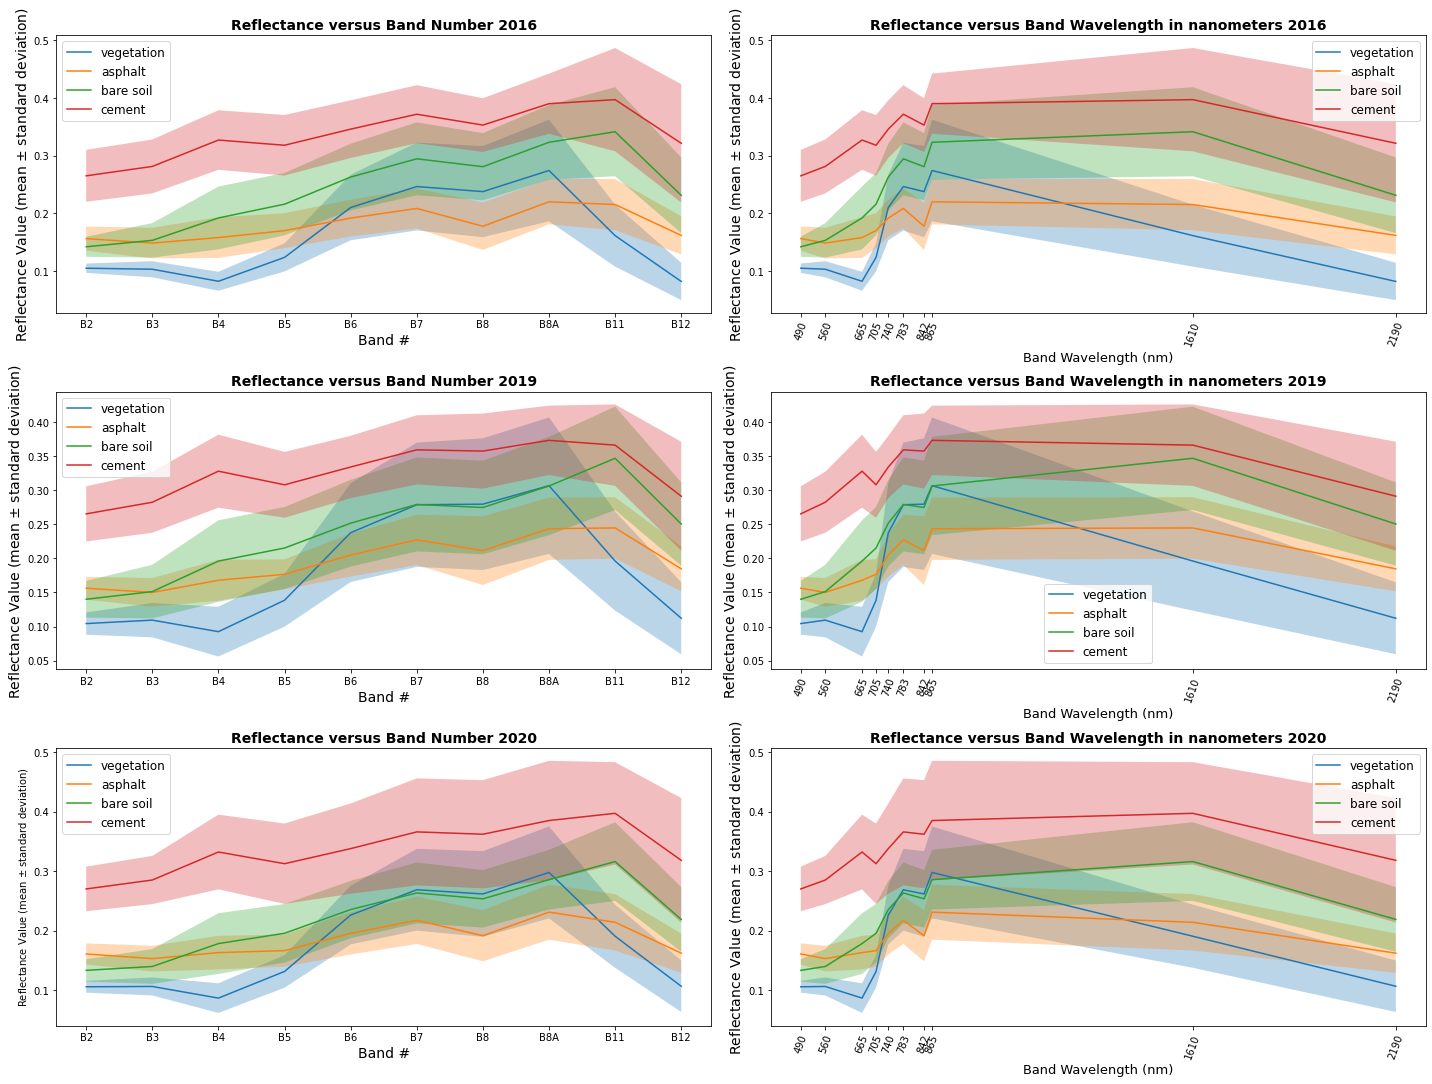

In [20]:
fig, axs = plt.subplots(3,2, figsize=(20,15))
all_labels = ['asphalt', 'bare soil' ,'cement', 'rocks' ,'tiled roof','vegetation', 'water']
labels_to_plot = ['vegetation', 'asphalt', 'bare soil','cement']

# loop through classes and plot the mean in each band
bands = range(1, n_bands+1)
for label in labels_to_plot:
    mean = np.mean(X[:, y==label], axis=1)
    std = np.std(X[:, y==label], axis=1)
    axs[0,0].fill_between(bands, mean-std, mean+std, alpha=0.3)
    axs[0,0].plot(bands, mean, label=label)
    axs[0,1].fill_between(band_wavelengths, mean-std, mean+std, alpha=0.3)
    axs[0,1].plot(band_wavelengths, mean, label=label)
axs[0,0].set_xticks(bands)
axs[0,0].set_xticklabels(band_list)
axs[0,0].set_xlabel('Band #', fontsize=14)
axs[0,0].set_ylabel('Reflectance Value (mean $\pm$ standard deviation)', fontsize=14)
axs[0,0].legend(fontsize=12)
axs[0,0].set_title('Reflectance versus Band Number 2016', fontsize=14,fontweight='bold')
axs[0,1].set_xticks(band_wavelengths)
axs[0,1].tick_params('x', labelrotation=70)
axs[0,1].set_xlabel('Band Wavelength (nm)', fontsize=13)
axs[0,1].set_ylabel('Reflectance Value (mean $\pm$ standard deviation)', fontsize=14)
axs[0,1].legend(fontsize=12)
axs[0,1].set_title('Reflectance versus Band Wavelength in nanometers 2016', fontsize=14,fontweight='bold')
fig.tight_layout()
# 2019
bands = range(1, n_bands_1+1)
for label in labels_to_plot:
    mean_1 = np.mean(X_1[:, y_1==label], axis=1)
    std_1 = np.std(X_1[:, y_1==label], axis=1)
    axs[1,0].fill_between(bands, mean_1-std_1, mean_1+std_1, alpha=0.3)
    axs[1,0].plot(bands, mean_1, label=label)
    axs[1,1].fill_between(band_wavelengths, mean_1-std_1, mean_1+std_1, alpha=0.3)
    axs[1,1].plot(band_wavelengths, mean_1, label=label)
axs[1,0].set_xticks(bands)
axs[1,0].set_xticklabels(band_list)
axs[1,0].set_xlabel('Band #', fontsize=14)
axs[1,0].set_ylabel('Reflectance Value (mean $\pm$ standard deviation)', fontsize=14)
axs[1,0].legend(fontsize=12)
axs[1,0].set_title('Reflectance versus Band Number 2019', fontsize=14,fontweight='bold')
axs[1,1].set_xticks(band_wavelengths)
axs[1,1].tick_params('x', labelrotation=70)
axs[1,1].set_xlabel('Band Wavelength (nm)', fontsize=13)
axs[1,1].set_ylabel('Reflectance Value (mean $\pm$ standard deviation)', fontsize=14)
axs[1,1].legend(fontsize=12)
axs[1,1].set_title('Reflectance versus Band Wavelength in nanometers 2019', fontsize=14,fontweight='bold')
fig.tight_layout()
# 2020
bands = range(1, n_bands_1+1)
for label in labels_to_plot:
    mean_2 = np.mean(X_2[:, y_2==label], axis=1)
    std_2 = np.std(X_2[:, y_2==label], axis=1)
    axs[2,0].fill_between(bands, mean_2-std_2, mean_2+std_2, alpha=0.3)
    axs[2,0].plot(bands, mean_2, label=label)
    axs[2,1].fill_between(band_wavelengths, mean_2-std_2, mean_2+std_2, alpha=0.3)
    axs[2,1].plot(band_wavelengths, mean_2, label=label)
axs[2,0].set_xticks(bands)
axs[2,0].set_xticklabels(band_list)
axs[2,0].set_xlabel('Band #', fontsize=14)
axs[2,0].set_ylabel('Reflectance Value (mean $\pm$ standard deviation)')
axs[2,0].legend(fontsize=12)
axs[2,0].set_title('Reflectance versus Band Number 2020', fontsize=14,fontweight='bold')
axs[2,1].set_xticks(band_wavelengths)
axs[2,1].tick_params('x', labelrotation=70)
axs[2,1].set_xlabel('Band Wavelength (nm)', fontsize=13)
axs[2,1].set_ylabel('Reflectance Value (mean $\pm$ standard deviation)', fontsize=14)
axs[2,1].legend(fontsize=12)
axs[2,1].set_title('Reflectance versus Band Wavelength in nanometers 2020', fontsize=14,fontweight='bold')

fig.tight_layout()